In [3]:
from commonfunctions import *
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes
import skimage
from skimage.color import rgb2gray
from skimage.morphology import disk, square, rectangle as rect
from skimage.filters import threshold_otsu, threshold_local

from skimage.morphology import(binary_erosion, 
                               binary_dilation,
                               binary_closing,
                               skeletonize,
                               thin,
                               opening
                              )
from skimage.measure import find_contours
from scipy.ndimage import binary_fill_holes
from skimage.draw import rectangle
import cv2
import scipy.stats
from sklearn import svm


In [130]:
# module is used for serializing and de-serializing a Python object structure.
import pickle
target_img_size = (32, 32)
def extract_hog_features(img):
    """
   (i.e win_size, cell_size, ... etc)
    arg: the input img
    return features
    """
    img = cv2.resize(img, target_img_size)
    win_size = (32, 32)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()


def get_model(fileName):
    '''
    arg: filename where needed model is found
    return one of the three trained model according to the specified fileName
    '''
    with open(fileName, 'rb') as file:
        model = pickle.load(file)
        return model
    return None

def makeSquare(image):
    '''
    resize image to square by taking the larger dimension of the image
    '''
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    h1 = image.shape[0]
    w1 = image.shape[1]
    w2 = max(h1, w1)
    out_image = np.zeros((w2,w2))

    if(w1 > h1):
        diff = w1 - h1
        out_image[diff//2:diff//2+h1,:] = image
    elif (w1 < h1):
        diff = h1 - w1
        out_image[:,diff//2:diff//2+w1] = image
    else:
        return image
    return out_image

    # Resize image to the given size
def resize_to_size(image, dsize):
    return cv2.resize(image, dsize)
    # return Binary image after preprocessing and thresholding
def pre_process(image,dsize):
    sq_image = makeSquare(image)
    resized_image = resize_to_size(sq_image, dsize)
    img = resized_image.copy()
    img = img.astype(np.uint8)
    ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th2
# get hog features of binary preprocessed image
def get_features(img):
    img = pre_process(img, (50,50))
    features = extract_hog_features(img)  
    return features
    

In [5]:
# classes
# contain the info of the staff lines
class staff_meta(object):
    division_height = -1 # distance between 2 lines in the same staff 
    line_thickness = -1 # thickness of the staff line 
    staff_lines_y_coords = [] # Y Co-ordinates of the staff lines

# contain the naming of the staff lines from bottom to up with thier factor
class notes_pitch(object):
    char =   ['e','f','g','a','b','c','d','e','f']
    factor = [ 1 , 1 , 1 , 1 , 1 , 2 , 2 , 2 , 2 ]

# get a well defined staff_meta instance where it get all the needed info
def get_trace_meta(image):
    if len(image.shape) != 2:
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    else:
        gray = image        
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    width = gray.shape[1]//5
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (width,1))

    # thresh = cv2.Canny(thresh, 30, 200) 
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    division_height=0
    h_max = 1
    bounding_rects = []
    for c in cnts:
        bounding_rects.append(cv2.boundingRect(c))

    for b_rect in bounding_rects:
        X,Y,w,h = b_rect
        if h > h_max:
            h_max = h
    def contour_y(c):
        return c[1]
    bounding_rects = sorted(bounding_rects, key=contour_y)
    lines_y_coordinates = [ b[1] for b in bounding_rects]
    div_height = bounding_rects[1][1] - bounding_rects[0][1]
    s_meta = staff_meta()
    s_meta.division_height = div_height
    s_meta.line_thickness = h_max
    s_meta.staff_lines_y_coords = lines_y_coordinates
    return s_meta
def padd_image(img):
    """
    this functions padds an image this is very important 
    when applying erosion as applying erosion to border 
    may result false postives
    """
    out_img = np.zeros((img.shape[0]+2,img.shape[1]+2), dtype=np.uint8)
    out_img[1:out_img.shape[0]-1,1:out_img.shape[1]-1] = img
    return out_img


In [24]:
# Functions Used in Image Processing 
#return the level of the char
def get_noteLine_depending_height(centers,boxes_start_point,trace_info):
    #trace_info: staff_meta = get_trace_meta(Charimg)#[Ymin:Ymax,Xmin:Xmax])
    #boxes_start_point = is the Xmin & Ymin of the bounding box in order to localize the center with respect to the whole image
    #centers = filled_holes_centers(char, radius)
    
    level = []
    for center in centers:
        x = center[0]
        y = center[1]
        x += boxes_start_point[0]
        y += boxes_start_point[1]
        factor = 0
        # if the center is above the highest staff line then decrease it by octave 3.5*(trace_info.division_height + 0.75*trace_info.line_thickness)
        while trace_info.staff_lines_y_coords[0] > y:
            factor += 1
            y += 3.5*(trace_info.division_height + 0.75*trace_info.line_thickness)
        # if the center is below the lowest staff line then increase it by octave 3.5*(trace_info.division_height + 0.75*trace_info.line_thickness)
        while trace_info.staff_lines_y_coords[4] < y:
            factor -= 1
            y -= 3.5*(trace_info.division_height + 0.75*trace_info.line_thickness)
        map = []
        map.append(trace_info.staff_lines_y_coords[4])
        i = 4
        while i > 0:
            map.append((trace_info.staff_lines_y_coords[i] + trace_info.staff_lines_y_coords[i-1]) / 2)
            map.append(trace_info.staff_lines_y_coords[i-1])
            i -= 1
        map = [abs(x - y) for x in map]
        pos = map.index(min(map))
        obj = notes_pitch()
        level.append([obj.char[pos], obj.factor[pos] + factor])
    return level

In [128]:
def filled_holes_centers(char, radius):
    """
    returns: the centers of the filed holes found in the sym_image
    eg: [(x1,y1), (x2,y2)]
    arguments:
    sym_image: this is an image of small size where the filled_ovals
    """
    padded_char = padd_image(char)    
    erroded_image = cv2.erode(padded_char,kernel=disk(radius),iterations = 1)        
    b_boxes = get_external_bounding_boxes(erroded_image)
    centers = []
    for box in b_boxes:
        X,Y,w,h = box
        cx = X+w//2
        cy=Y+h//2
        centers.append((cx,cy))

    return centers
######################NEW BY OMAR################
def halfsCenter(char, radius):

    """
    returns: the centers of the half note found in the sym_image
    eg: [(x1,y1)]
    arguments:
    sym_image: this is an image of small size where the filled_ovals
    """
    
    padded_char = padd_image(char)
    dim = round(np.sqrt(char.shape[1]))
    se = np.ones((dim,dim))
    dilated_char = binary_dilation(padded_char,se)
    dilated_char = dilated_char.astype(np.uint8)
    dilated_char = binary_fill_holes(dilated_char).astype(np.uint8)
    erroded_image = cv2.erode(dilated_char,kernel=disk(radius),iterations = 1)
    b_boxes = get_external_bounding_boxes(erroded_image)
    centers = []
    for box in b_boxes:
        X,Y,w,h = box
        cx = X+w//2
        cy=Y+h//2
        centers.append((cx,cy))

    return centers
    
def WholesCenter(char):
    """
    returns: the centers of the whole note found in the sym_image
    eg: [(x1,y1)]
    arguments:
    sym_image: this is an image of small size where the whole
    """
    center = []
    x,y = char.shape
    x = x/2
    y = y/2
    center.append((x,y))
    return center


In [18]:
def conv_255_true(image):
    image[image == 255] = True
    image[image == 0] = False
    return image
def remove_horizontal_wrapper(org_image, inv_image):
    # both org_image and inv_image must uint8 
    line_width, no_staf_1 = remove_horizontal_lines(org_image)
    no_staf_1 = conv_255_true(no_staf_1)
    no_staf = no_staf_1
    inv_image = conv_255_true(inv_image)
    no_staf = np.bitwise_and(no_staf, inv_image)
    return no_staf
def remove_horizontal_lines(image):
    if len(image.shape) != 2:
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    width = gray.shape[1]//5
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (width,1))

    # thresh = cv2.Canny(thresh, 30, 200) 
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    h_max = 1
    for c in cnts:
        X,Y,w,h = cv2.boundingRect(c)
        if h > h_max:
            h_max=h
    for c in cnts:   
        cv2.drawContours(gray, [c], -1, 255, h_max)


    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,h_max*3))
    result = 255-cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
    result = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    return h_max,result

In [19]:
def get_external_bounding_boxes(img):
    """
    this function takes and image and returns an array
    of bounding rectangle [(X1,Y1,W1,H1),(X2,Y2,W2,H2),....]
    where 
    Wi: is the width
    Hi: is the height
    """
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    bounding_rects = []
    for c in cnts:
        b_r = cv2.boundingRect(c)
        # X,Y,w,h = b_r
        bounding_rects.append(b_r)    # 
    def contour_x(c):
        return c[0]
    bounding_rects = sorted(bounding_rects, key=contour_x)
    return bounding_rects
def draw_external_bounding_boxes(img,b_rects):
    out = img.copy()
    for b_r in b_rects:
        X,Y,w,h = b_r
        out = cv2.rectangle(out, (X,Y), (X+w, Y+h),1,3)
    return out

In [20]:
# common functions
def binary_opening(img, selem):
    return binary_dilation(binary_erosion(img, selem=selem), selem=selem)

def get_bounding_boxes(img,box_aspect_ratio):
    """
    summary: this function returns the bounding boxes sorted according to x-min
    parameter:
    img: is a binary image for which to find the contours 
    aspect_ratio: is a tuple where (low_aspect_ratio,high_aspect_ratio)
    """
    contours = find_contours(img,.8, fully_connected="low")
    bounding_boxes=[]
    for contour in contours:
        Xmin= np.min(contour[:,1])
        Xmax=np.max(contour[:,1]) 
        Ymin=np.min(contour[:,0])
        Ymax = np.max(contour[:,0])
        if(Ymax-Ymin != 0):
            aspect_ratio = (Xmax-Xmin)/(Ymax-Ymin)
        else:
            aspect_ratio = 3000
            
        if aspect_ratio >= box_aspect_ratio[0] and aspect_ratio <= box_aspect_ratio[1]:
            bounding_boxes.append([int(round(Xmin)),int(round(Xmax)),int(round(Ymin)),int(round(Ymax))])
    
    
    def x_min(shape):
        return shape[0]             

    bounding_boxes = sorted(bounding_boxes, key=x_min)
    return bounding_boxes


def get_bounded_image(img,bounding_boxes):
    conte = np.zeros(img.shape)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
        rr = rr.astype(np.int)
        cc= cc.astype(np.int)
        conte[rr, cc] = 1 #set color white
    img2 = np.where(conte==1, img, 0)
    return img2
# used to draw bounding boxes around the char
def draw_bounding_boxes(img,bounding_boxes):
    conte = np.zeros(img.shape)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
        rr = rr.astype(np.int)
        cc= cc.astype(np.int)
        conte[rr, cc] = 1 #set color white
    img2 = np.where(conte==1, img, 0)
    show_images([conte,img2], ['bounding_boxes','original segmented'])


In [21]:
# load the models
training_files_names = [
    '0_oval_model_4',
    '1_oval_model_4',
    '2_oval_model_4',
]
models = []
for train_file in training_files_names:
    model = get_model('models/{}'.format(train_file))
    models.append(model)

In [22]:
accidentals = {
    "c":"#", # this for sharp #
    "d":"", # this for the natural or neutral
    "e":"&", # this is for the b
    "ee":"&&", # this is for the bb
    "x":"##" , # this for the x or double sharp
}

duration_map = {
    "a_1":"1",
    "a_2":"2",
    "a_8":"8",
    "a_16":"16",
    "a_32":"32",
    "b_8":"8",
    "b_16":"16",
    "b_32":"32"

}
class NOTE:
    coord = (-1,-1)
    note_type ="" # this can be number accidental beam chord note clef 
    pitches = [] # this can be either a1, b2, c3, d1 (every pitch has tow characters eg a,1)
    duration = None # this can be 4 8 16 or 32
    accedintal_type=""
    def representation():
        out_str = ""
        if note_type == "beam":
            for i,pitch in enumerate(pitches):
                outt_str += pitch+"/"+duration
                if i != len(pitches) - 1:
                    out_str += " "
        elif note_type == "chord":
            out_str += "{"
            for i, pitch in enumerate(pitches):
                out_str += pitch + "/" + duration
                if i != len(pitches) - 1:
                    out_str += ","
            out_str += "}"
        elif note_type == "note":
            out_str = pitches[0][0] + accidental + pitches[0][1] + "/" + duration
        return out_str
  
def is_accidental(char):
    return char in accidentals
is_accidental("e")

True

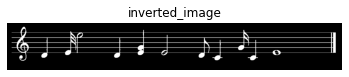

[0, 171]
0
[[0, 0, 1505, 171]]


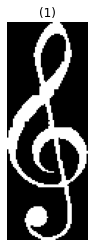

aspect ratio 0.3691275167785235
oval_centers  []
this is may be a clef, half, whole , a number or accidentals noise or beam
the model says: ['z']


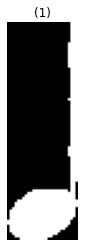

aspect ratio 0.32558139534883723
oval_centers  [(14, 77)]
this maybe a quarter or 8th or 16th or 32th or a clef
the model says: ['a_4']
Center is ::  (14, 77)
Before Center X =  14 center Y = 77
After Center X =  168 center Y = 149
trace Info: Line Thickness 2 trace info: division height 22
trace Info: Ycord [46, 68, 90, 112, 135]
Box start point Info: x 154
box start point Info: y 72
DEC fac
After INC and DEC Center X =  168 center Y = 66.75
Before abs MAP:  [135, 123.5, 112, 101.0, 90, 79.0, 68, 57.0, 46]
MAP:  [68.25, 56.75, 45.25, 34.25, 23.25, 12.25, 1.25, 9.75, 20.75]
POS:  6
[['d', 1]]


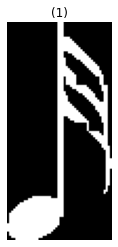

aspect ratio 0.4807692307692308
oval_centers  [(14, 94)]
this maybe a quarter or 8th or 16th or 32th or a clef
the model says: ['a_32']
Center is ::  (14, 94)
Before Center X =  14 center Y = 94
After Center X =  275 center Y = 136
trace Info: Line Thickness 2 trace info: division height 22
trace Info: Ycord [46, 68, 90, 112, 135]
Box start point Info: x 261
box start point Info: y 42
DEC fac
After INC and DEC Center X =  275 center Y = 53.75
Before abs MAP:  [135, 123.5, 112, 101.0, 90, 79.0, 68, 57.0, 46]
MAP:  [81.25, 69.75, 58.25, 47.25, 36.25, 25.25, 14.25, 3.25, 7.75]
POS:  7
[['e', 1]]


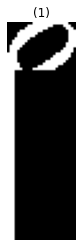

aspect ratio 0.313953488372093
oval_centers  []
this is may be a clef, half, whole , a number or accidentals noise or beam
the model says: ['a_2']


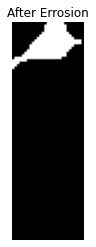

Here half center is   [(14, 9)]
Center is ::  (14, 9)
Before Center X =  14 center Y = 9
After Center X =  328 center Y = 58
trace Info: Line Thickness 2 trace info: division height 22
trace Info: Ycord [46, 68, 90, 112, 135]
Box start point Info: x 314
box start point Info: y 49
After INC and DEC Center X =  328 center Y = 58
Before abs MAP:  [135, 123.5, 112, 101.0, 90, 79.0, 68, 57.0, 46]
MAP:  [77, 65.5, 54, 43.0, 32, 21.0, 10, 1.0, 12]
POS:  7
[['e', 2]]


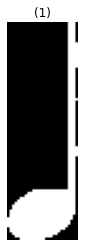

aspect ratio 0.32558139534883723
oval_centers  [(14, 77)]
this maybe a quarter or 8th or 16th or 32th or a clef
the model says: ['a_4']
Center is ::  (14, 77)
Before Center X =  14 center Y = 77
After Center X =  495 center Y = 149
trace Info: Line Thickness 2 trace info: division height 22
trace Info: Ycord [46, 68, 90, 112, 135]
Box start point Info: x 481
box start point Info: y 72
DEC fac
After INC and DEC Center X =  495 center Y = 66.75
Before abs MAP:  [135, 123.5, 112, 101.0, 90, 79.0, 68, 57.0, 46]
MAP:  [68.25, 56.75, 45.25, 34.25, 23.25, 12.25, 1.25, 9.75, 20.75]
POS:  6
[['d', 1]]


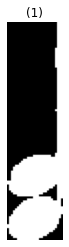

aspect ratio 0.2545454545454545
oval_centers  [(14, 100), (15, 78)]
this is a chord
Center is ::  (14, 100)
Before Center X =  14 center Y = 100
After Center X =  601 center Y = 136
trace Info: Line Thickness 2 trace info: division height 22
trace Info: Ycord [46, 68, 90, 112, 135]
Box start point Info: x 587
box start point Info: y 36
DEC fac
After INC and DEC Center X =  601 center Y = 53.75
Before abs MAP:  [135, 123.5, 112, 101.0, 90, 79.0, 68, 57.0, 46]
MAP:  [81.25, 69.75, 58.25, 47.25, 36.25, 25.25, 14.25, 3.25, 7.75]
POS:  7
Center is ::  (15, 78)
Before Center X =  15 center Y = 78
After Center X =  602 center Y = 114
trace Info: Line Thickness 2 trace info: division height 22
trace Info: Ycord [46, 68, 90, 112, 135]
Box start point Info: x 587
box start point Info: y 36
After INC and DEC Center X =  602 center Y = 114
Before abs MAP:  [135, 123.5, 112, 101.0, 90, 79.0, 68, 57.0, 46]
MAP:  [21, 9.5, 2, 13.0, 24, 35.0, 46, 57.0, 68]
POS:  2
[['e', 1], ['g', 1]]


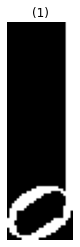

aspect ratio 0.30337078651685395
oval_centers  []
this is may be a clef, half, whole , a number or accidentals noise or beam
the model says: ['a_2']


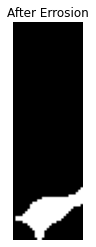

Here half center is   [(15, 80)]
Center is ::  (15, 80)
Before Center X =  15 center Y = 80
After Center X =  709 center Y = 138
trace Info: Line Thickness 2 trace info: division height 22
trace Info: Ycord [46, 68, 90, 112, 135]
Box start point Info: x 694
box start point Info: y 58
DEC fac
After INC and DEC Center X =  709 center Y = 55.75
Before abs MAP:  [135, 123.5, 112, 101.0, 90, 79.0, 68, 57.0, 46]
MAP:  [79.25, 67.75, 56.25, 45.25, 34.25, 23.25, 12.25, 1.25, 9.75]
POS:  7
[['e', 1]]


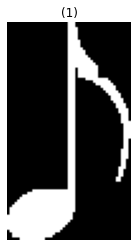

aspect ratio 0.5697674418604651
oval_centers  [(14, 77)]
this maybe a quarter or 8th or 16th or 32th or a clef
the model says: ['a_8']
Center is ::  (14, 77)
Before Center X =  14 center Y = 77
After Center X =  875 center Y = 149
trace Info: Line Thickness 2 trace info: division height 22
trace Info: Ycord [46, 68, 90, 112, 135]
Box start point Info: x 861
box start point Info: y 72
DEC fac
After INC and DEC Center X =  875 center Y = 66.75
Before abs MAP:  [135, 123.5, 112, 101.0, 90, 79.0, 68, 57.0, 46]
MAP:  [68.25, 56.75, 45.25, 34.25, 23.25, 12.25, 1.25, 9.75, 20.75]
POS:  6
[['d', 1]]


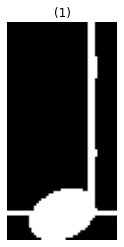

aspect ratio 0.5056179775280899
oval_centers  [(24, 79)]
this maybe a quarter or 8th or 16th or 32th or a clef
the model says: ['a_4']
Center is ::  (24, 79)
Before Center X =  24 center Y = 79
After Center X =  947 center Y = 159
trace Info: Line Thickness 2 trace info: division height 22
trace Info: Ycord [46, 68, 90, 112, 135]
Box start point Info: x 923
box start point Info: y 80
DEC fac
After INC and DEC Center X =  947 center Y = 76.75
Before abs MAP:  [135, 123.5, 112, 101.0, 90, 79.0, 68, 57.0, 46]
MAP:  [58.25, 46.75, 35.25, 24.25, 13.25, 2.25, 8.75, 19.75, 30.75]
POS:  5
[['c', 1]]


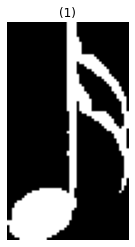

aspect ratio 0.5568181818181818
oval_centers  [(15, 78)]
this maybe a quarter or 8th or 16th or 32th or a clef
the model says: ['a_16']
Center is ::  (15, 78)
Before Center X =  15 center Y = 78
After Center X =  1053 center Y = 114
trace Info: Line Thickness 2 trace info: division height 22
trace Info: Ycord [46, 68, 90, 112, 135]
Box start point Info: x 1038
box start point Info: y 36
After INC and DEC Center X =  1053 center Y = 114
Before abs MAP:  [135, 123.5, 112, 101.0, 90, 79.0, 68, 57.0, 46]
MAP:  [21, 9.5, 2, 13.0, 24, 35.0, 46, 57.0, 68]
POS:  2
[['g', 1]]


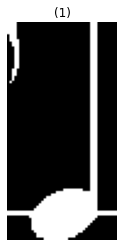

aspect ratio 0.5056179775280899
oval_centers  [(24, 79)]
this maybe a quarter or 8th or 16th or 32th or a clef
the model says: ['a_4']
Center is ::  (24, 79)
Before Center X =  24 center Y = 79
After Center X =  1106 center Y = 159
trace Info: Line Thickness 2 trace info: division height 22
trace Info: Ycord [46, 68, 90, 112, 135]
Box start point Info: x 1082
box start point Info: y 80
DEC fac
After INC and DEC Center X =  1106 center Y = 76.75
Before abs MAP:  [135, 123.5, 112, 101.0, 90, 79.0, 68, 57.0, 46]
MAP:  [58.25, 46.75, 35.25, 24.25, 13.25, 2.25, 8.75, 19.75, 30.75]
POS:  5
[['c', 1]]


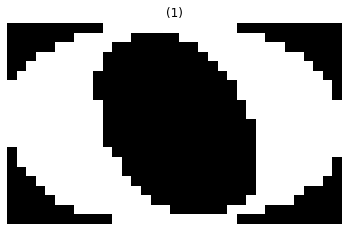

aspect ratio 1.6666666666666667
oval_centers  []
this is may be a clef, half, whole , a number or accidentals noise or beam
the model says: ['a_1']
Whole center is : X =  10.5  y =  17.5
Center is ::  (10.5, 17.5)
Before Center X =  10.5 center Y = 17.5
After Center X =  1204.5 center Y = 142.5
trace Info: Line Thickness 2 trace info: division height 22
trace Info: Ycord [46, 68, 90, 112, 135]
Box start point Info: x 1194
box start point Info: y 125
DEC fac
After INC and DEC Center X =  1204.5 center Y = 60.25
Before abs MAP:  [135, 123.5, 112, 101.0, 90, 79.0, 68, 57.0, 46]
MAP:  [74.75, 63.25, 51.75, 40.75, 29.75, 18.75, 7.75, 3.25, 14.25]
POS:  7
[['e', 1]]


aspect ratio 0.046511627906976744
oval_centers  []
this is may be a clef, half, whole , a number or accidentals noise or beam
the model says: ['noise']


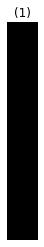

aspect ratio 0.13953488372093023
oval_centers  []
this is may be a clef, half, whole , a number or accidentals noise or beam
the model says: ['noise']


In [129]:

images_paths = [ f"test-cases/0{i+1}.PNG" for i in range(9)]

images_paths.append("test-cases/10.PNG")
images_paths.append("test-cases/11.PNG")
images_paths.append("images/16_sheet_001.jpg")
images_paths.append("images/8_sheet_001.jpg")
images_paths.append("images/32_sheet_001.jpg")
images_paths.append("images/AllSheet2.PNG")

images_paths.append("images/music1.JPG")
images_paths.append("images/music2.JPG")
images_paths.append("images/music3.JPG")


original_image = cv2.imread(images_paths[0])
gray_image = np.round(rgb2gray(original_image)*255)
binary_image = binarize(gray_image)
inverted_image = 255 - binary_image
show_images([inverted_image], ['inverted_image'])

# img be binarized image of size height x width and foregound pixel is white i.e pixel value = 255
horizontal_hist = np.sum(inverted_image,axis=1,keepdims=True)/255

# plt.plot([i for i in range(horizontal_hist.shape[0])], horizontal_hist)

peaks = 0
offset = 1
j = 0
th = int(round(np.max(horizontal_hist)*.95))
staff_lines_y=[]
while j < len(horizontal_hist):
    while j < len(horizontal_hist) and horizontal_hist[j] < th:
        j+=1

    if j >= len(horizontal_hist):
        break
    staff_lines_y.append(j)    
    peaks+=1
    st = j
    while j < len(horizontal_hist) and horizontal_hist[j] >= th:
        j+=offset
number_of_staffs = int(round(peaks/ 5))

min_areas_coords = []

min_areas_coords.append([0, staff_lines_y[0]])

j = 4
while j < len(staff_lines_y) - 5:
    print(j)
    min_areas_coords.append([staff_lines_y[j],staff_lines_y[j+1]])
    j+=5
min_areas_coords.append([staff_lines_y[len(staff_lines_y)-1],gray_image.shape[0]])

division_height = staff_lines_y[1] - staff_lines_y[0]

thresh_span = division_height # minimum must span thin number of pixels
separation_ys = []
for min_pair in min_areas_coords:
    i = min_pair[0]
    minimum = i
    min_span = 1
    i+=1
    while i < min_pair[1]:
        if horizontal_hist[minimum] <= horizontal_hist[i]:
            min_span += 1
        else:
            min_span=1
            minimum = i
        i+=1
    separation_ys.append(minimum)

print(separation_ys)
staff_boxes = [] # stored as Xmin, Ymin, W, H
for i in range(len(separation_ys)-1):
    print(separation_ys[i])
    W =inverted_image.shape[1]
    H = separation_ys[i+1] - separation_ys[i]
    staff_boxes.append([0, separation_ys[i], W, H])
print(staff_boxes)
for i,box in enumerate(staff_boxes):
    Xmin,Ymin, W, H = box
    Ymax = Ymin+H
    Xmax = Xmin + W
    orig_inv_staff = inverted_image[Ymin:Ymax,Xmin:Xmax].astype(np.uint8)

    no_staf=remove_horizontal_wrapper(original_image[Ymin:Ymax,Xmin:Xmax],inverted_image[Ymin:Ymax,Xmin:Xmax].astype(np.uint8) )
    char_boxes = get_external_bounding_boxes(no_staf)
    out = draw_external_bounding_boxes(no_staf, char_boxes)
    koko = 0
    trace_info: staff_meta = get_trace_meta(original_image[Ymin:Ymax,Xmin:Xmax])

    for box in char_boxes:
        [Xmin, Ymin, W, H] = [x for x in box]
        # remove blank or noisy area that is less than a line of pixels
        char = no_staf[Ymin:Ymin+H,Xmin:Xmin+W]
        # remove it
        radius = int(trace_info.division_height // 3 )
        oval_centers = filled_holes_centers(char, radius)
        show_images([char])
        print("aspect ratio", W/H)
        print("oval_centers ",oval_centers)
        if W < trace_info.division_height//2 and H < trace_info.division_height//2:
            # use the properties of a dot or circle to know for sure it is a dot
            print("this may be a dot or noise")
            erroded = padd_image(char)
            aspect_ratio = W/H
            if(aspect_ratio > 0.5 and aspect_ratio < 1.5 ):
                print("this is dot probably sum: {}".format(np.sum(char)))
                erroded = cv2.morphologyEx(erroded, cv2.MORPH_ERODE, disk(W//4), iterations=1)
                show_images([erroded], ["dot erroded"])
            else:
                print("this is noise")
        else:
            if len(oval_centers) == 0:
                # use sift to distinguish between them
                print("this is may be a clef, half, whole , a number or accidentals noise or beam")
                char_type = models[0].predict([get_features(char)])
                print("the model says: {}".format(char_type))
                if char_type == 'a_1':
                    oval_centers = WholesCenter(char)
                    level = get_noteLine_depending_height(oval_centers,(Xmin,Ymin),trace_info)
                    print(level)
                elif char_type == 'a_2':
                    oval_centers = halfsCenter(char,radius)
                    print("Here half center is  ", oval_centers)
                    level = get_noteLine_depending_height(oval_centers,(Xmin,Ymin),trace_info)
                    print(level)


            elif len(oval_centers) == 1:
                print("this maybe a quarter or 8th or 16th or 32th or a clef")
                char_type = models[1].predict([get_features(char)])
                print("the model says: {}".format(char_type))
                level = get_noteLine_depending_height(oval_centers,(Xmin,Ymin),trace_info)
                print(level)
            elif len(oval_centers) >= 2:
                # print("this note is beamed or chords")
                # using the x difference between the 1st 2 centre we can separate between chords 
                # or beams
                if oval_centers[1][0] - oval_centers[0][0] > int(1.5*trace_info.division_height):
                    print("this is a beam")
                    # the model has very low accuracy
                    # so i will try hough transform
                    beam_type = models[2].predict([get_features(char)])
                    print("the model says: {}".format(beam_type))
                    level = get_noteLine_depending_height(oval_centers,(Xmin,Ymin),trace_info)
                    print(level)
                else:
                    print("this is a chord")
                    level = get_noteLine_depending_height(oval_centers,(Xmin,Ymin),trace_info)
                    print(level)


